In [1]:
import os
import pickle
import time
import numpy as np
import json
import matplotlib.pyplot as plt

# utils imports
from power_planner.data_reader import DataReader
from power_planner import graphs
from power_planner.plotting import plot_path_costs, plot_pipeline_paths, plot_path, plot_k_sp
from power_planner.utils import get_distance_surface, time_test_csv
from config import Config

#### General configurations

In [5]:
PATH_FILES = "../data/belgium_instance1"

# DEFINE CONFIGURATION
ID = "w_ksp_5"  # str(round(time.time() / 60))[-5:]

OUT_PATH = "outputs/path_" + ID
SCALE_PARAM = 5  # args.scale
# normal graph pipeline
# PIPELINE = [(2, 50), (1, 0)]  # [(1, 0)]  # [(4, 80), (2, 50), (1, 0)]  #
# random graph pipeline
PIPELINE = [(1, 0)]  # [(0.9, 40), (0, 0)]

GRAPH_TYPE = graphs.WeightedKSP
# LineGraph, WeightedGraph, RandomWeightedGraph, RandomLineGraph, PowerBF
# TwoPowerBF, WeightedKSP
print("graph type:", GRAPH_TYPE)
# summarize: mean/max/min, remove: all/surrounding, sample: simple/watershed
NOTES = "None"  # "mean-all-simple"

IOPATH = os.path.join(PATH_FILES, "data_dump_" + str(SCALE_PARAM) + ".dat")

cfg = Config(SCALE_PARAM)

graph type: <class 'power_planner.graphs.weighted_ksp.WeightedKSP'>
defined pylon distances in raster: 3.0 5.0


## Load data

In [6]:
# READ DATA
with open(IOPATH, "rb") as infile:
    data = pickle.load(infile)
    (instance, instance_corr, start_inds, dest_inds) = data.data

In [8]:
graph = GRAPH_TYPE(
    instance, instance_corr, graphtool=cfg.GTNX, verbose=cfg.VERBOSE
)

graph.set_edge_costs(
    data.layer_classes, data.class_weights, angle_weight=cfg.ANGLE_WEIGHT
)
graph.set_shift(
    cfg.PYLON_DIST_MIN,
    cfg.PYLON_DIST_MAX,
    dest_inds - start_inds,
    cfg.MAX_ANGLE,
    max_angle_lg=cfg.MAX_ANGLE_LG
)
# add vertices
graph.add_nodes()

# START PIPELINE
tic = time.time()
corridor = np.ones(instance_corr.shape) * 0.5  # start with all
output_paths = []
plot_surfaces = []
time_infos = []

for (factor, dist) in PIPELINE:
    print("----------- PIPELINE", factor, dist, "---------------")
    graph.set_corridor(corridor, start_inds, dest_inds, factor_or_n_edges=factor)
    print("1) set cost rest")
    graph.add_edges()
    print("2) added edges", graph.n_edges)
    print("number of vertices:", graph.n_nodes)

    # weighted sum of all costs
    graph.sum_costs()
    source_v, target_v = graph.add_start_and_dest(start_inds, dest_inds)
    print("3) summed cost, get source and dest")
    # get actual best path
    path, path_costs, cost_sum = graph.get_shortest_path(source_v, target_v)
    print("4) shortest path")
    # save for inspection
    output_paths.append((path, path_costs))
    plot_surfaces.append(graph.cost_rest[2].copy())  # TODO: mean makes black
    # get several paths --> here: pareto paths
    paths = [path]
    # graph.get_pareto(
    #     np.arange(0, 1.1, 0.1), source_v, target_v, compare=[2, 3]
    # )

    time_infos.append(graph.time_logs.copy())

    if cfg.VERBOSE:
        del graph.time_logs['edge_list_times']
        del graph.time_logs['add_edges_times']
        print(graph.time_logs)

    if dist > 0:
        # PRINT AND SAVE timing test
        time_test_csv(
            ID, cfg.CSV_TIMES, SCALE_PARAM, cfg.GTNX, GRAPH_TYPE, graph,
            path_costs, cost_sum, dist, 0, NOTES
        )
        # do specified numer of dilations
        corridor = get_distance_surface(
            graph.pos2node.shape, paths, mode="dilation", n_dilate=dist
        )
        print("5) compute distance surface")
        # remove the edges of vertices in the corridor (to overwrite)
        graph.remove_vertices(corridor, delete_padding=cfg.PYLON_DIST_MAX)
        print("6) remove edges")

initialized weighted graph pos2node
['cultural', 'human', 'planning', 'technical'] [0.28571429 0.35714286 0.14285714 0.21428571]
Added nodes: 37960 in time: 0.01781010627746582
----------- PIPELINE 1 0 ---------------
1) set cost rest
n_neighbors: 28
Done adding edges: 483010
DONE adding 483010 edges: 0.613062858581543
2) added edges 483010
number of vertices: 37960
3) summed cost, get source and dest
4) shortest path
{'init_graph': 0.0, 'add_nodes': 0.018, 'downsample': 0.0, 'set_cost_rest': 0.009, 'add_edges': 0.006, 'edge_list': 0.003, 'add_all_edges': 0.43, 'sum_of_costs': 0.015, 'shortest_path': 0.168}


out costs shape: (50, 4)


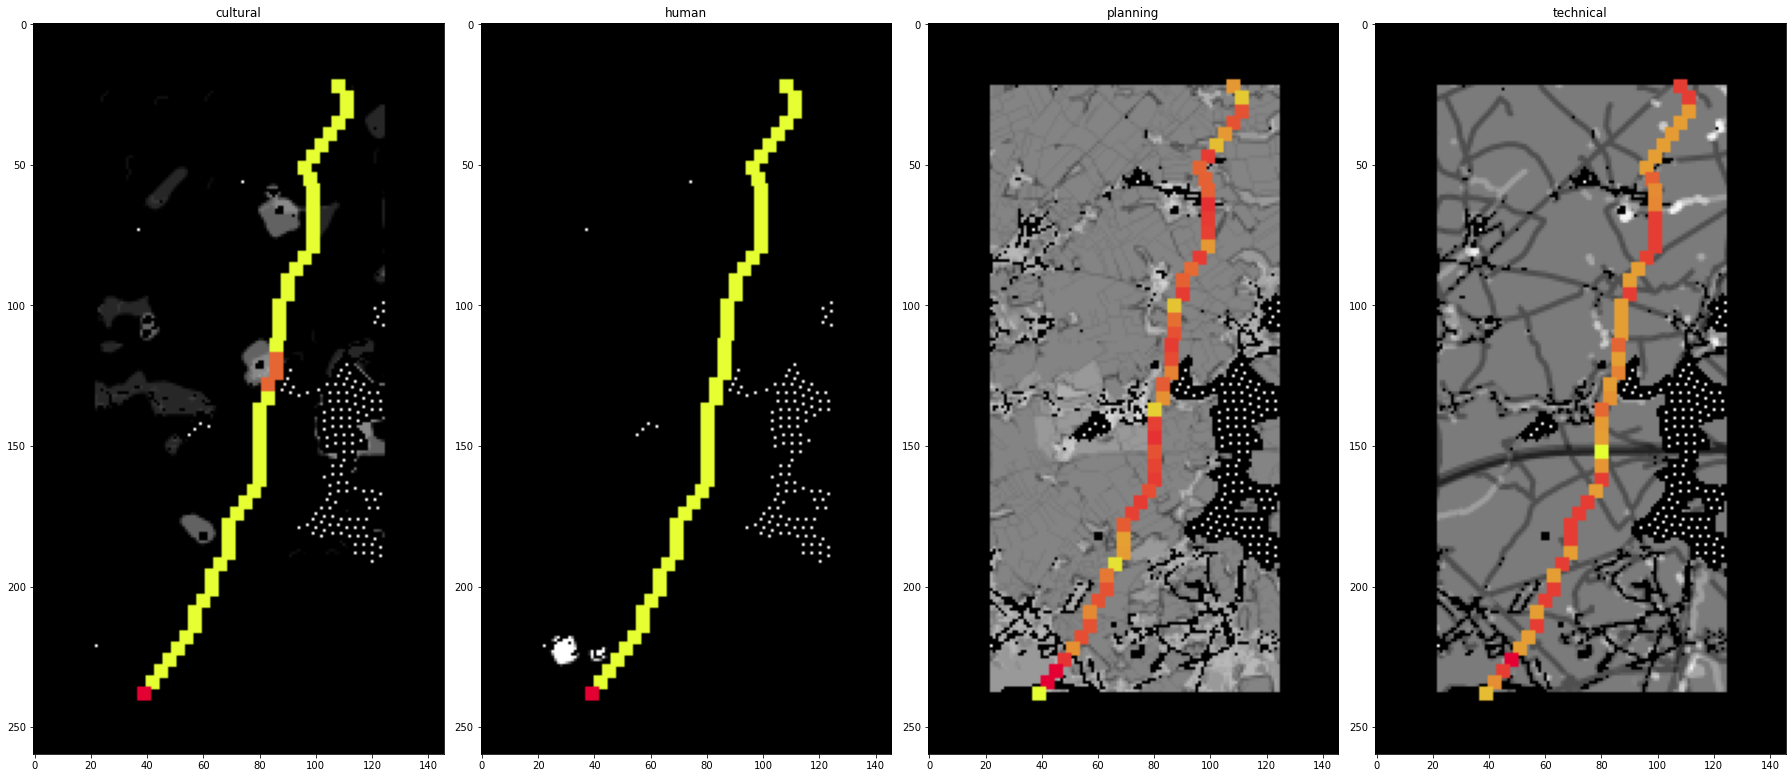

In [9]:
plot_path_costs(
    instance * instance_corr,
    path,
    path_costs,
    data.layer_classes,
    buffer=2
)

## Improve pareto computation

#### Notes:

We say that an alternative A dominates B if A outscores B regardless of the tradeoff between value and cost — that is, if A is both better and cheaper than B

In [6]:
import seaborn as sns
sns.set(style="ticks")

def plot_pareto_scatter_matrix(pareto, weights, classes):
    df = pd.DataFrame(pareto)
    sns.pairplot(df)

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd

def plot_pareto_3d(pareto, weights, classes):
    """
    3D plot of pareto points from 3 cost classes
    Arguments:
        pareto: np array of shape num_paths x 3, with costs for each path
        weights: array or list of shape num_paths x 3, giving the weights that yielded the pareto costs
        classes: list of 3 strings, the compared graphs
    """
    fig = plt.figure(figsize=(10,5))
    ax = Axes3D(fig)
    
    for i in range(len(pareto)):
        x, y, z = tuple(pareto[i])
        col_weights = (np.asarray([weights[i]])+0.4)/1.4
        # print(x,y,z, weights[i])
        ax.scatter(x, y, z, marker='o', s=100, c=col_weights, label=weights[i])

    ax.set_xlabel(classes[0], fontsize=15)
    ax.set_ylabel(classes[1], fontsize=15)
    ax.set_zlabel(classes[2], fontsize=15)
    # manually define legend
    legend_elements = [Line2D([0], [0],marker='o', color=[1,0,0], markersize=10, lw=0.1, label='only '+classes[0]),
                       Line2D([0], [0], marker='o', color=[0,1,0],lw=0.1, label='only '+classes[1], markersize=10),
                       Line2D([0], [0], marker='o', color=[0,0,1],lw=0.1, label='only '+classes[2], markersize=10)]

    # Create the figure
    ax.legend(handles=legend_elements, loc='upper center', fontsize=17)
    
    plt.show()

In [64]:
from matplotlib.lines import Line2D

def plot_pareto_scatter_3d(pareto, weights, classes):
    """
    3D plot of pareto points from 3 cost classes
    Arguments:
        pareto: np array of shape num_paths x 3, with costs for each path
        weights: array or list of shape num_paths x 3, giving the weights that yielded the pareto costs
        classes: list of 3 strings, the compared graphs
    """
    fig = plt.figure(figsize=(20,5))
    for i in range(3):
        ax = fig.add_subplot(1,3,i+1)
        ind1 = i
        ind2 = (i+1)%3
        for j in range(len(pareto)):
            label=np.argmax(weights[j])
            col_weights = (np.asarray([weights[j]])+0.4)/1.4
            ax.scatter(pareto[j,ind1], pareto[j,ind2], c=col_weights, label=label)
        plt.xlabel(classes[ind1], fontsize=17)
        plt.ylabel(classes[ind2], fontsize=17)
    legend_elements = [Line2D([0], [0],marker='o', color=[1,0,0], markersize=10, lw=0.1, label='only '+classes[0]),
                   Line2D([0], [0], marker='o', color=[0,1,0],lw=0.1, label='only '+classes[1], markersize=10),
                     Line2D([0], [0], marker='o', color=[0,0,1],lw=0.1, label='only '+classes[2], markersize=10)]

    # Create the figure
    ax.legend(handles=legend_elements, loc='upper center', fontsize=17)
    plt.savefig("pareto3d.pdf")
    plt.show()
    
def plot_pareto_scatter_2d(pareto, weights, classes):
    """
    Scatter to compare two cost classes
    Arguments:
        pareto: np array of shape num_paths x 2, with costs for each path
        weights: array or list of shape num_paths x 2, giving the weights that yielded the pareto costs
        classes: list of 2 strings, the compared graphs
    """
    color = np.array([[w[0], 0, w[1]] for w in weights])
    # scatter pareto curve
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.scatter(pareto[:,0], pareto[:,1], c=color)
    plt.xlabel(classes[0], fontsize=15)
    plt.ylabel(classes[1], fontsize=15)
    # manually create legend
    legend_elements = [Line2D([0], [0],marker='o', color=[1,0,0], markersize=10, lw=0.1, label='only '+classes[0]),
                   Line2D([0], [0], marker='o', color=[0,0,1],lw=0.1, label='only '+classes[1], markersize=10)]
    # Create the figure
    plt.legend(handles=legend_elements, loc='upper center', fontsize=17)
    plt.title("Pareto frontier for " + classes[0] + " vs " + classes[1])
    plt.show()

In [26]:
def get_pareto(self, vary, source, dest, out_path=None, non_compare_weight=0, compare=[0, 1],plotting=False):
    """
    Arguments:
        vary: how many weights to explore, e.g 3 --> each cost class can have weight 0, 0.5 or 1
        source, dest: as always the source and destination vertex
        out_path: where to save the pareto figure(s)
        compare: indices of cost classes to compare
    Returns:
        paths: All found paths
        pareto: The costs for each combination of weights
    """
    # initialize lists
    pareto = list()
    paths = list()
    cost_sum = list()
    # 
    cost_arrs = [cost.get_array() for cost in self.cost_props]
    # [self.cost_props[comp].get_array() for comp in compare]
    var_weights = np.around(np.linspace(0,1, vary),2)
    
    if len(compare)==2:
        weights = [[v, 1-v] for v in var_weights]
    elif len(compare)==3:
        weights = list()
        for w0 in var_weights:
            for w1 in var_weights[var_weights<=1-w0]:
                weights.append([w0, w1, 1-w0-w1])
    else:
        raise ValueError("argument compare can only have length 2 or 3")
    
    best_sum = []
    w_avail = np.sum(np.asarray(self.cost_weights)[compare])
    print(w_avail)
    for j in range(len(weights)):
        w = self.cost_weights.copy() # np.zeros(len(cost_arrs)) + non_compare_weight
        w[compare] = np.array(weights[j])*w_avail # replace these ones
        # print(w)
        self.weight.a = np.sum([cost_arrs[i] * w[i] for i in range(len(cost_arrs))], axis=0)
        # get shortest path
        path, path_costs, _ = self.get_shortest_path(source, dest)
        pareto.append(np.sum(path_costs, axis=0)[compare])
        print(np.sum(path_costs, axis=0))
        print(w)
        print(np.sum(path_costs))
        print("--------")
        paths.append(path)
        cost_sum.append(np.sum(path_costs))

    # print best weighting
    best_weight = np.argmin(cost_sum)
    w = self.cost_weights.copy()
    w[compare] = np.array(weights[best_weight]) * w_avail
    print("Best weights:", w, "with (unweighted) costs:", np.min(cost_sum))
            
    pareto = np.array(pareto)
    classes = [self.cost_classes[comp] for comp in compare]
    # Plotting
    if plotting:
        if len(compare)==2:
            plot_pareto_scatter_2d(pareto, weights, classes)
        elif len(compare)==3:
            # plot_pareto_3d(pareto, weights, classes)
            plot_pareto_scatter_3d(pareto, weights, classes)
        # TODO: return weights as well
    return paths, weights, cost_sum

In [16]:
%matplotlib notebook

In [27]:
pareto_out = get_pareto(
    graph, 10, source_v, target_v, compare=[2, 3], non_compare_weight=0.5, out_path=1, plotting=False
)

0.3571428571428571
[ 0.90509122  0.25586045 26.43666045 17.67517079]
[0.28571429 0.35714286 0.         0.35714286]
45.27278290404598
--------
[ 0.90509122  0.25586045 26.27666045 17.67517079]
[0.28571429 0.35714286 0.03928571 0.31785714]
45.112782904045986
--------
[ 0.83739891  0.25586045 25.54546045 17.88344665]
[0.28571429 0.35714286 0.07857143 0.27857143]
44.52216645842264
--------
[ 0.79124506  0.25586045 23.30226045 18.77448114]
[0.28571429 0.35714286 0.11785714 0.23928571]
43.123847095027415
--------
[ 0.71739891  0.25586045 23.03026045 19.01586045]
[0.28571429 0.35714286 0.15714286 0.2       ]
43.019380251526094
--------
[ 0.80355276  0.25586045 22.34226045 19.49723976]
[0.28571429 0.35714286 0.2        0.15714286]
42.89891340802477
--------
[ 0.80355276  0.25586045 22.34226045 19.49723976]
[0.28571429 0.35714286 0.23928571 0.11785714]
42.89891340802477
--------
[ 0.53278352  0.25586045 22.34226045 20.2489639 ]
[0.28571429 0.35714286 0.27857143 0.07857143]
43.37986831518657
---

In [91]:
pareto_out[2]

[8.759911072733738,
 8.690354422487433,
 8.272047488042567,
 7.784877196265379,
 7.752159348595806,
 7.758752452044082,
 7.8361742027072125,
 7.9092955365457875,
 7.983368442949729,
 8.24880777603044]

In [24]:
def plot_pareto_paths(pareto_out, inst, out_path=None):
    """
    Plot k shortest paths on the instance
    Arguments:
        pareto_out: tuple of pareto outputs: (paths, weights, cost sums)
        inst: instance to plot on
    """
    # get relevant information
    paths, weight_colours, cost_sum = pareto_out 

    # plot main image (cost surface)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.swapaxes(inst, 1, 0))
    # iterate over k shortest paths
    for i, path in enumerate(paths):
        path = np.asarray(path)
        col = weight_colours[i]
        if len(col)==2:
            col = [col[0],0,col[1]]
        plt.plot(
            path[:, 0], path[:, 1], label=str(round(cost_sum[i], 2)), c= col, linewidth=3
        )
    # plot and save
    leg = plt.legend(fontsize=15)
    leg.set_title('Weighted costs', prop={'size': 15})
    plt.axis("off")
    if out_path is not None:
        plt.savefig(out_path + "_pareto_paths.pdf")
    else:
        plt.show()

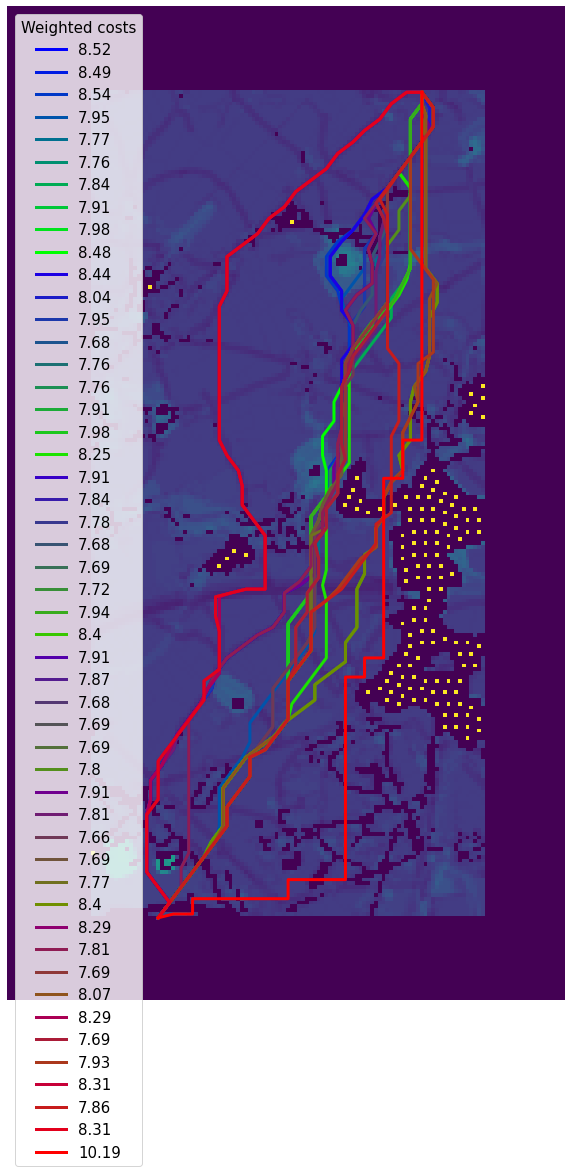

In [25]:
plot_pareto_paths(pareto_out, graph.instance)

## Plotting

<IPython.core.display.Javascript object>


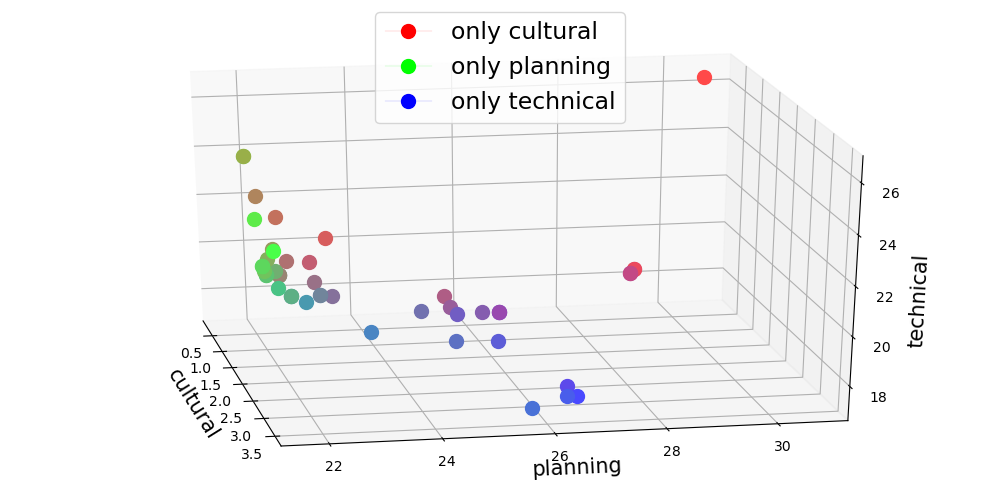

In [24]:
pareto_paths = get_pareto_3d(
    graph, 3, source_v, target_v, compare=[0, 2, 3], non_compare_weight=0.5, out_path=1
)

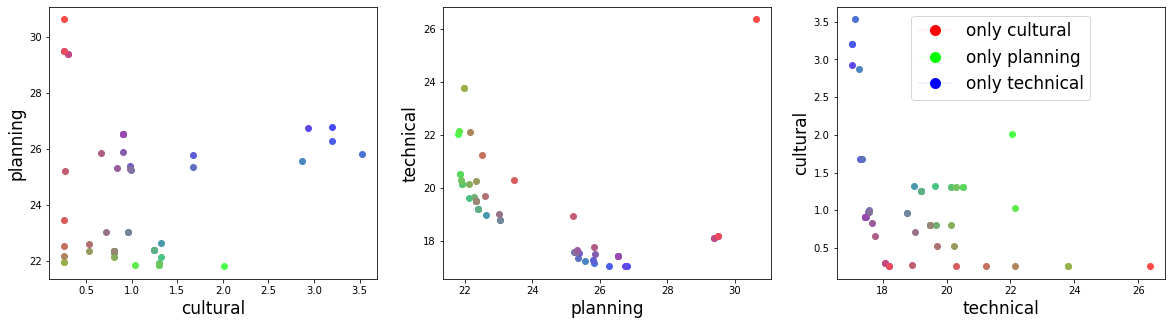

In [11]:
paths = get_pareto(
    graph, 10, source_v, target_v, compare=[0, 2, 3], out_path=1
)

### Interpretaion: 
* possible to optimize for cultural and technical costs simultanously
* if planning and cultural minimized, then technical tends to be high

## Check random corridor

In [35]:
from power_planner.utils import normalize

In [166]:
corridor_dilate = get_distance_surface(
            instance_corr.shape, [path], mode="dilation", n_dilate=50
        )
factor = 0.9

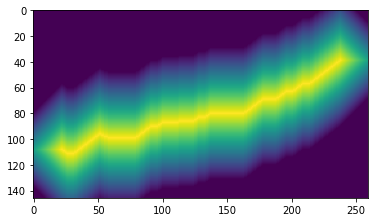

In [167]:
plt.imshow(corridor_dilate)

In [168]:
corridor = corridor_dilate.copy()

In [169]:
corridor = normalize(gauss(normalize(corridor)))

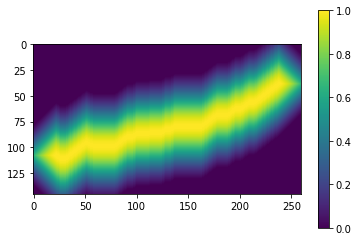

In [170]:
plt.imshow(corridor)
plt.colorbar()
plt.show()

In [171]:
m = np.mean(corridor)
m

0.34876352013497247

In [172]:
want_mean = 1-factor
scale_factor = want_mean/m
corridor = corridor*scale_factor
arr = np.random.rand(*corridor.shape)
corr_thresh = (corridor>arr).astype(int)

In [178]:
print(len(corridor_dilate[corridor_dilate>0]))

24647


In [128]:
corr_greater_zero = corridor[corridor > 0]
cutoff = np.quantile(corr_greater_zero, factor)
print(cutoff)
if cutoff == 1:
    corridor = corridor - factor
else:
    corridor = corridor + 0.5 - max([cutoff, 0.5])

0.9855789256584598


In [173]:
arr = np.random.rand(*corridor.shape)
corr_thresh = (corridor>arr).astype(int)

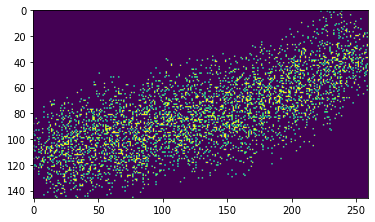

In [174]:
plt.imshow(corr_thresh)
# plt.colorbar()
plt.show()

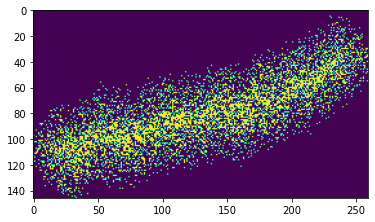

In [51]:
plt.imshow(corr_thresh)
# plt.colorbar()
plt.show()

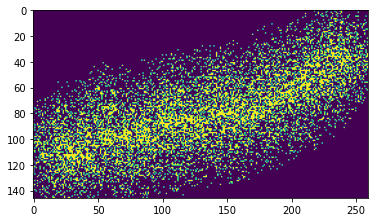

In [57]:
plt.imshow(corr_thresh)
# plt.colorbar()
plt.show()

In [102]:
flipped = (np.unique(corridor_dilate).tolist())
flipped.reverse()
onedim = normalize(np.array(np.unique(corridor_dilate).tolist() + flipped))

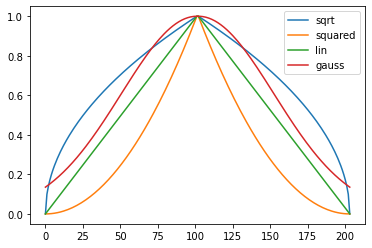

In [116]:
# plt.plot(np.log(onedim))
plt.plot(np.sqrt(onedim), label="sqrt")
plt.plot(onedim**2, label="squared")
plt.plot(normalize(onedim), label="lin")
plt.plot(gauss(onedim), label="gauss")
plt.legend()
plt.show()

In [135]:
gauss = lambda x: np.exp(-(x-1)**2/(0.5))

In [111]:
gauss(0.5)

0.8824969025845955

### Observations:

corr so small because negative values! --> half of the corridor just vanishes
--> would need to take values close to 0.5 instead -> still using half of the points

and actually not even 0.5, but such that cutoff corridor is at 0.5!

In [148]:
arr1 = np.random.rand(1000)*0.2

In [149]:
np.mean(arr1)

0.09916950185417783

In [153]:
arr2 = np.random.rand(1000)

In [154]:
np.sum((arr1>arr2).astype(bool))/1000

0.101

In [ ]:
# need to scale mean of corridor!

### New method (not cutting off corridor)

In [390]:
corridor_dilate = get_distance_surface(
            instance_corr.shape, [path], mode="dilation", n_dilate=30
        )
factor = 0.3

In [392]:
corridor = corridor_dilate.copy()

In [393]:
mode = "gauss"
if mode == "gauss":
    gauss = lambda x: np.exp(-(x - 1)**2 / (4))
    corridor = normalize(gauss(normalize(corridor)))
elif mode == "same":
    corridor = normalize(corridor)
elif mode == "squared":
    corridor = normalize(corridor)**2
elif mode == "squareroot":
    corridor = np.sqrt(normalize(corridor))
else:
    raise NotImplementedError("mode must be gauss, squared...")

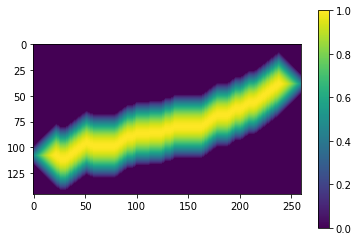

In [394]:
plt.imshow(corridor)
plt.colorbar()
plt.show()

In [395]:
mean_val_now = np.mean(corridor[corridor>0])
n_entris = len(corridor_dilate[corridor_dilate>0])
print("entries orig", len(corridor_dilate[corridor_dilate>0]), "entries now", len(corridor[corridor>0]))

entries orig 14892 entries now 14892


In [396]:
if mean_val_now > 1-factor:
    scale_factor = (1-factor)/mean_val_now
    print("scale_factor", scale_factor)
    corridor = corridor*scale_factor
else:
    scale_factor = factor/(1-mean_val_now)
    print("scale_factor", scale_factor)
    larger_zero = (corridor>0).astype(int)
    corridor = 1-scale_factor + corridor*scale_factor
    # have to reset to 0
    corridor = corridor*larger_zero

scale_factor 0.8436019038797664


In [397]:
print(np.mean(corridor[corridor>0]), "should be", (1-factor))

0.7000000000000001 should be 0.7


In [398]:
arr = np.random.rand(*corridor.shape)
corr_thresh = (corridor>arr).astype(int)

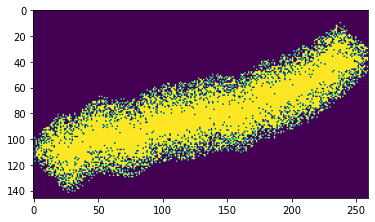

In [399]:
# plt.figure(figsize=(20,10))
plt.imshow(corr_thresh)
plt.show()

In [400]:
arr = np.random.rand(*corridor.shape)
corr_thresh = (corridor>arr).astype(int)
leftover=len(corr_thresh[corr_thresh>0])
print("entries leftover", leftover)

entries leftover 10470


In [401]:
print("RATIO DEL",(n_entris-leftover)/ n_entris,"should be", factor)

RATIO DEL 0.2969379532634972 should be 0.3


In [402]:
n_entris

14892

In [403]:
15000000 #edges actually

15000000

In [404]:
250 * 550 * 150

20625000

In [ ]:
# get entries of hard_constraints
# n_nodes_hard = len(self.hard_constraints[self.hard_constraints > 0])

n_edges_desired = 5000000
n_nodes_hard = len(corridor[corridor > 0])
# edges_approx is the number of edges we would get if we take the whole corridor
n_edges_approx = len(self.shifts) * n_nodes_hard
print("desired", n_edges_desired, "n nodes in corridor", n_nodes_hard, "approximate_edges", n_edges_approx)

# ratio of edges to delete x
ratio_keep = (n_edges_desired/n_edges_approx)
# in the beginning: second part is 1, so simply taking the edge ratio
# later: second part is smaller, so deleting less edges
# min because might happen that corridor has less edges anyways then the desired maximum
factor = min([1-ratio_keep, 1])
print(ratio_keep, factor)

In [435]:
np.random.permutation(30)

array([20, 24, 19, 26, 29, 18,  2,  1,  7, 28, 23,  0, 25, 22,  6,  3,  4,
        8, 16, 14, 17, 10, 12,  9, 15, 27, 21, 11, 13,  5])

# Improve ksp

In [10]:
from graph_tool.all import shortest_distance

In [21]:
def get_shortest_path_tree(self, source, target):
    tic = time.time()

    self.dist_map_ab, self.pred_map_ab = shortest_distance(
        self.graph,
        source,
        weights=self.weight,
        negative_weights=True,
        directed=self.graph.is_directed(),
        pred_map=True
    )
    # turn around edge directions
    # Attention: is_reversed must be True when it has NOT been reversed
    #   before
    self.graph.set_reversed(is_reversed=True)
    self.dist_map_ba, self.pred_map_ba = shortest_distance(
        self.graph,
        target,
        weights=self.weight,
        negative_weights=True,
        pred_map=True,
        directed=self.graph.is_directed()
    )
    # again turn around to recover graph
    self.graph.set_reversed(is_reversed=False)
    self.time_logs["shortest_path_tree"] = round(time.time() - tic, 3)

    path_ab = self.get_sp_from_preds(self.pred_map_ab, target, source)
    assert self.dist_map_ba[source] < np.inf, "s not reachable from t"
    path_ab.reverse()
    self.best_path = path_ab
    
def similarity(s1, s2, mode="IoU"):
    path_inter = len(s1.intersection(s2))
    if mode=="IoU":
        return path_inter/len(s1.union(s2))
    elif mode=="sim2paper":
        return path_inter/(2*len(s1)) + path_inter/(2*len(s2))
    elif mode=="sim3paper":
        return np.sqrt(path_inter**2 / (len(s1)*len(s2)))
    elif mode=="max_norm_sim":
        return path_inter/(max([len(s1), len(s2)]))
    elif mode=="min_norm_sim":
        return path_inter/(min([len(s1), len(s2)]))
    else:
        raise NotImplementedError("mode wrong, not implemented yet")

def k_shortest_paths(self, source, dest, k, overlap=0.5, mode="myset"):
    tic = time.time()
    # initialize list of paths
    sp_set = set(self.best_path)
    best_paths = [self.best_path]
    best_path_sets = [set(self.best_path)]
    # get list of vertices = unique values in pos2node except -1
    vertices = np.unique(self.pos2node)[1:]
    v_dists = [self.dist_map_ab[v] + self.dist_map_ba[v] for v in vertices]
    # sort paths
    v_shortest = np.argsort(v_dists)
    # iterate over vertices starting from shortest paths
    # times_getpath = []
    for j, v_ind in enumerate(v_shortest):
        v = vertices[v_ind]
        # TODO: for runtime scan only every xth one (anyways diverse)
        if v not in sp_set:
            # do not scan unreachable vertices
            if int(self.pred_map_ab[v]
                   ) == int(v) or int(self.pred_map_ba[v]) == int(v):
                continue
            # tic1 = time.time()
            try:
                path_ac = self.get_sp_from_preds(
                    self.pred_map_ab, v, source
                )
                path_cb = self.get_sp_from_preds(self.pred_map_ba, v, dest)
            except RuntimeWarning:
                print("while loop not terminating")
                continue
            # times_getpath.append(time.time() - tic1)
            path_ac.reverse()
            # concatenate - leave 1 away because otherwise twice
            vertices_path = path_ac + path_cb[1:]
            
            # similar = similarity(vertices_path, best_paths, sp_set)
            if mode!="myset":
                sofar = np.array([similarity(sp, set(vertices_path), mode) for sp in best_path_sets])
                if np.all(sofar<overlap):
                    best_paths.append(vertices_path)
                    best_path_sets.append(set(vertices_path))
            # mode myset --> my version: set of all paths together 
            else:
                already = np.array([u in sp_set for u in vertices_path])
                if np.sum(already) < len(already) * overlap:
                    best_paths.append(vertices_path)
                    sp_set.update(vertices_path)
                # print("added path, already scanned", j)
        # stop if k paths are sampled
        if len(best_paths) >= k:
            break

    self.time_logs["ksp"] = round(time.time() - tic, 3)
    return [self.transform_path(p) for p in best_paths]

In [12]:
get_shortest_path_tree(graph, source_v, target_v)

In [22]:
ksp = k_shortest_paths(graph, source_v, target_v, 10, overlap=0.5, mode="sim3paper")

In [474]:
print([k[2] for k in ksp])

[8.400987541092965, 8.11073971994859, 8.095676438402553, 8.242587541092963, 8.298807927603004, 8.296934793840215, 8.574409291756094, 8.400634073870533, 8.34205946227523, 8.661039075765188]


### Compare all similarity metrics with threshold 0.5

---------------   MODE:  myset -------------------


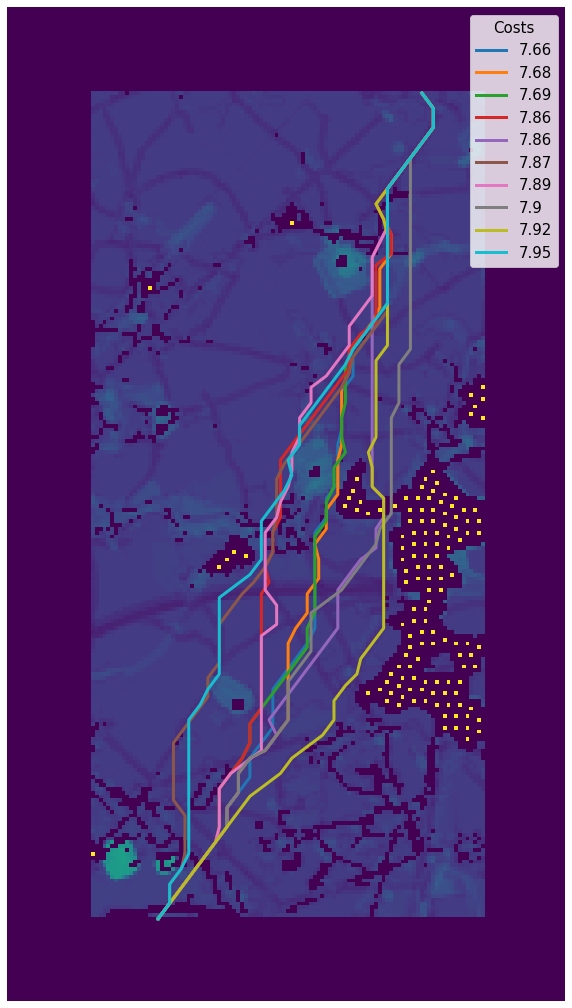

---------------   MODE:  IoU -------------------


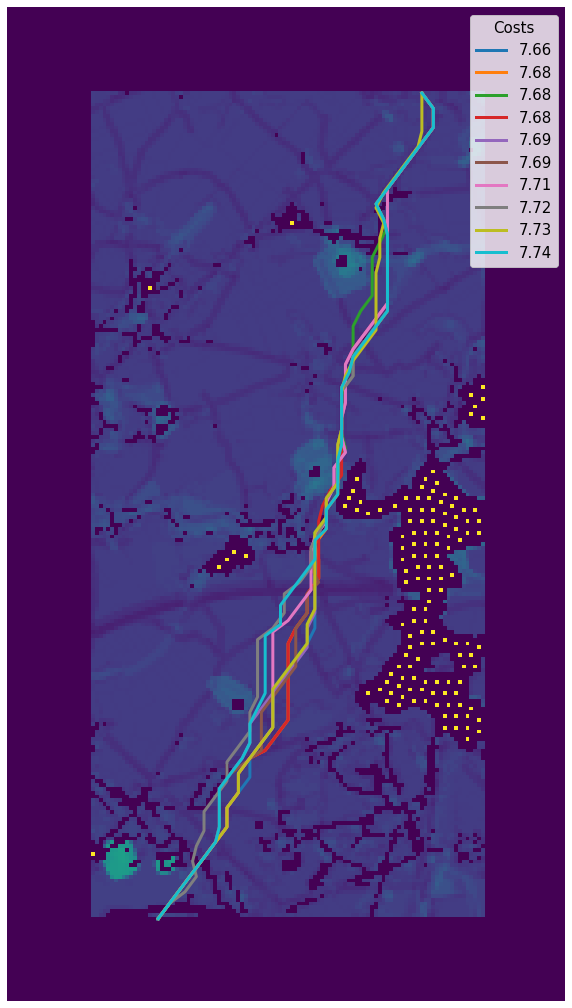

---------------   MODE:  sim2paper -------------------


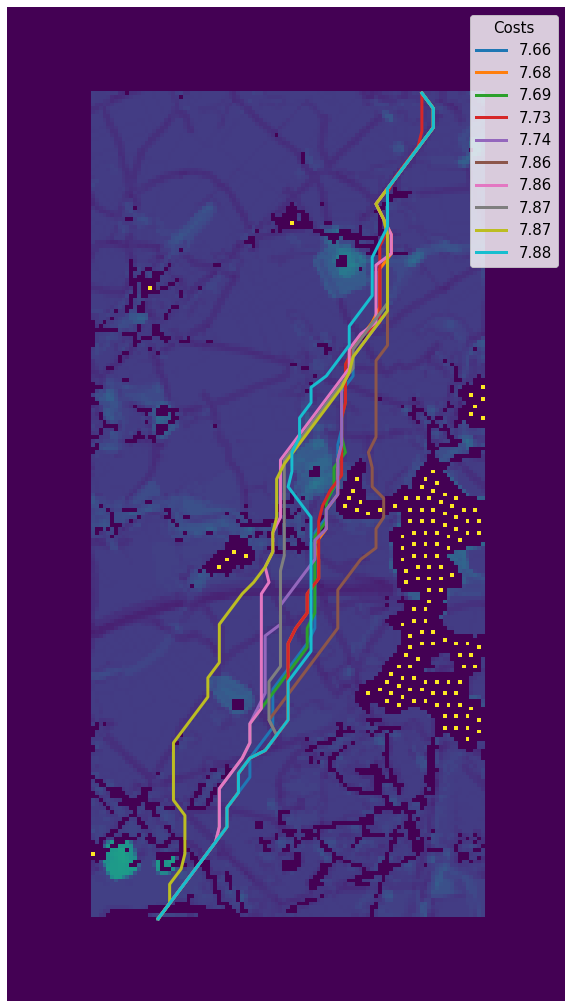

---------------   MODE:  sim3paper -------------------


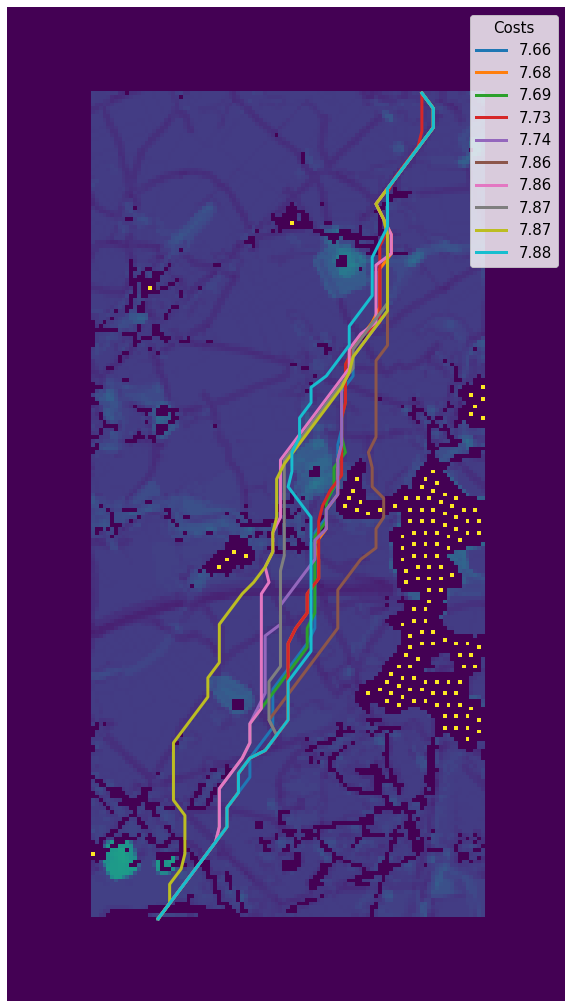

---------------   MODE:  max_norm_sim -------------------


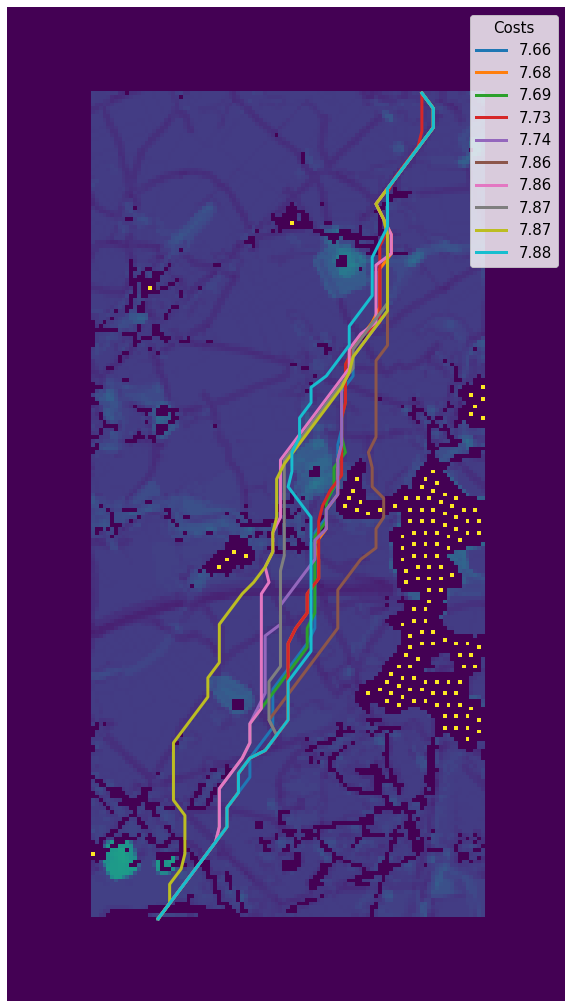

---------------   MODE:  min_norm_sim -------------------


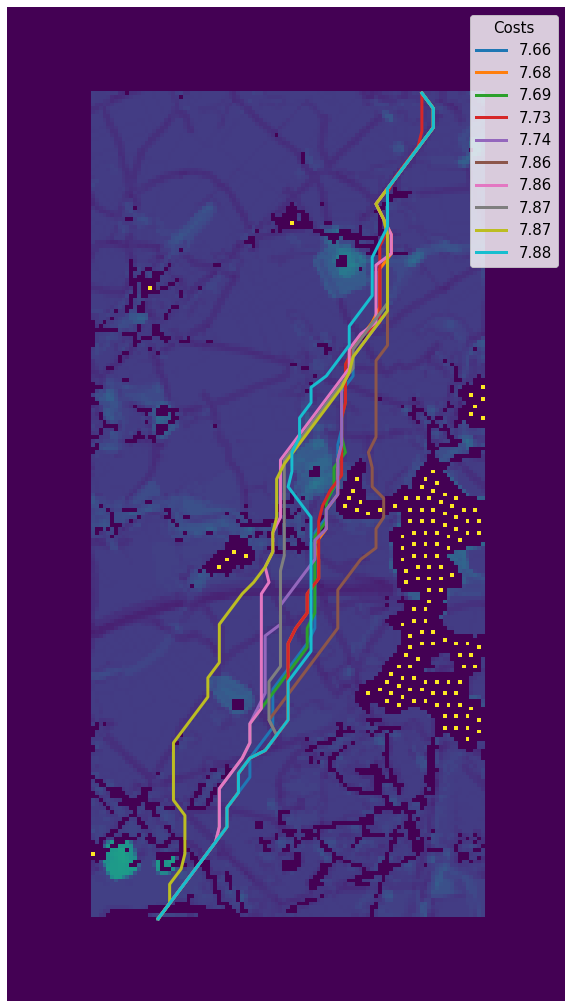

In [25]:
for mode in ["myset", "IoU","sim2paper", "sim3paper", "max_norm_sim", "min_norm_sim"]:
    ksp = k_shortest_paths(graph, source_v, target_v, 10, overlap=0.5, mode=mode)
    print("---------------   MODE: ", mode, "-------------------")
    plot_k_sp(ksp, graph.instance, out_path=None)

### Compare all similarity metrics with threshold 0.3

---------------   MODE:  myset -------------------


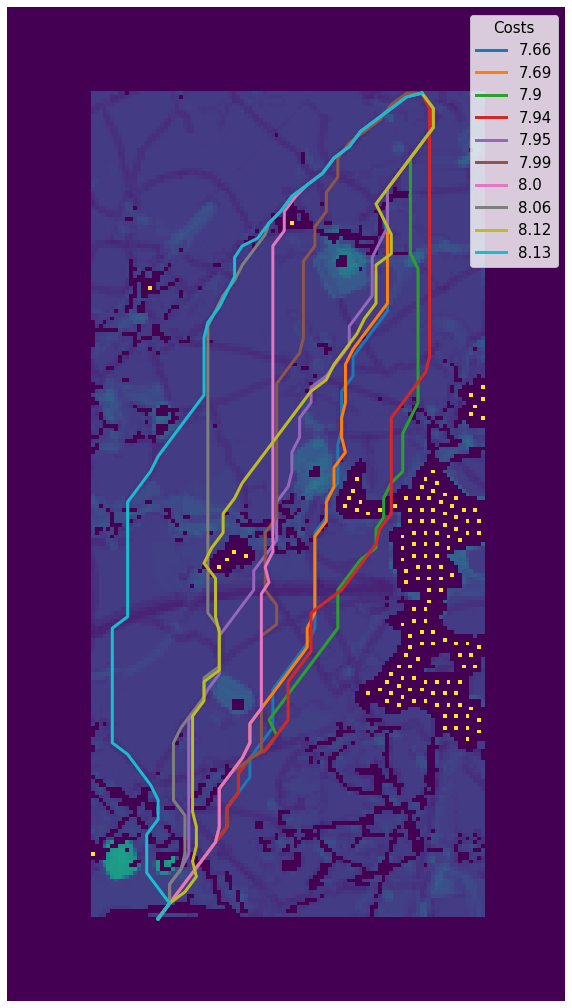

---------------   MODE:  IoU -------------------


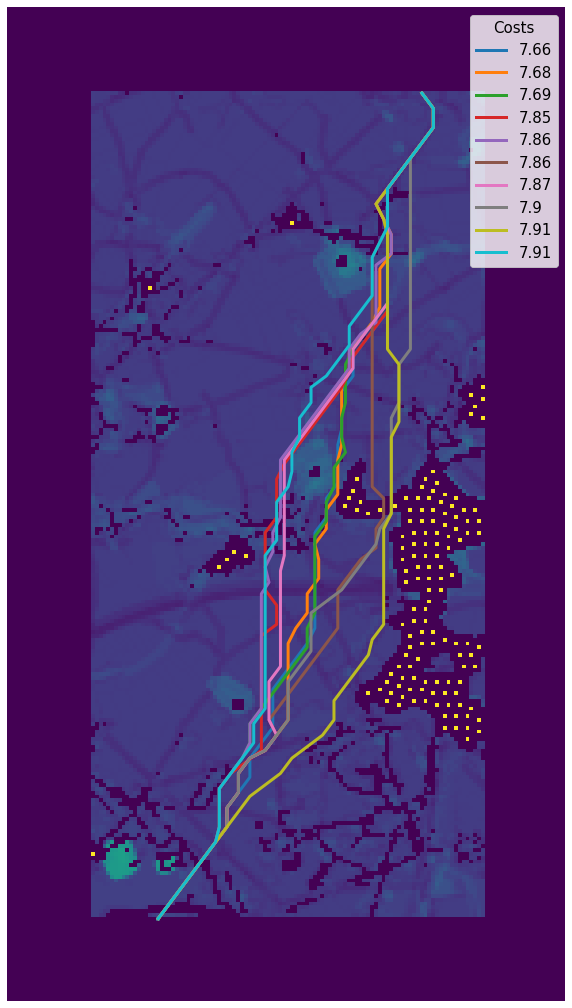

---------------   MODE:  sim2paper -------------------


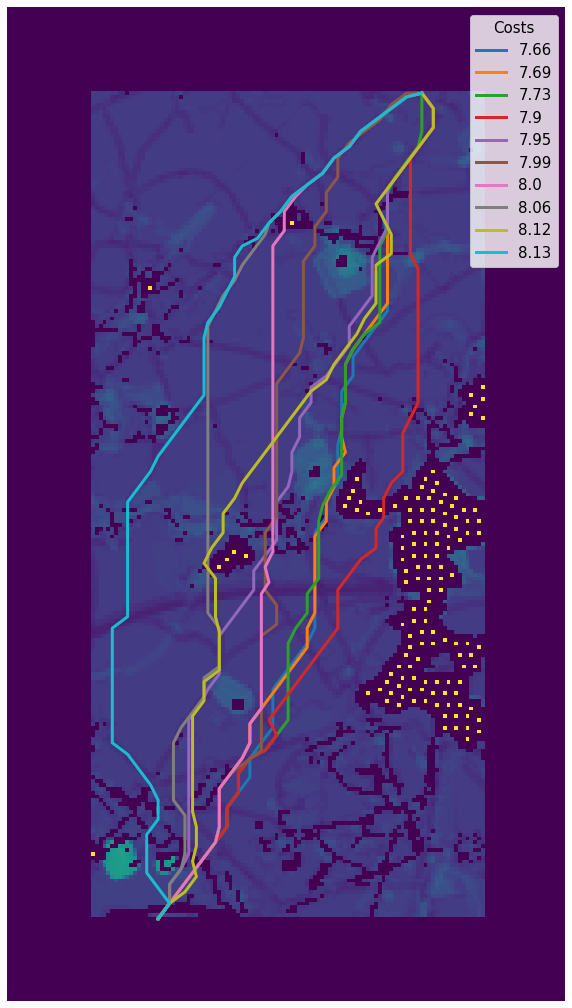

---------------   MODE:  sim3paper -------------------


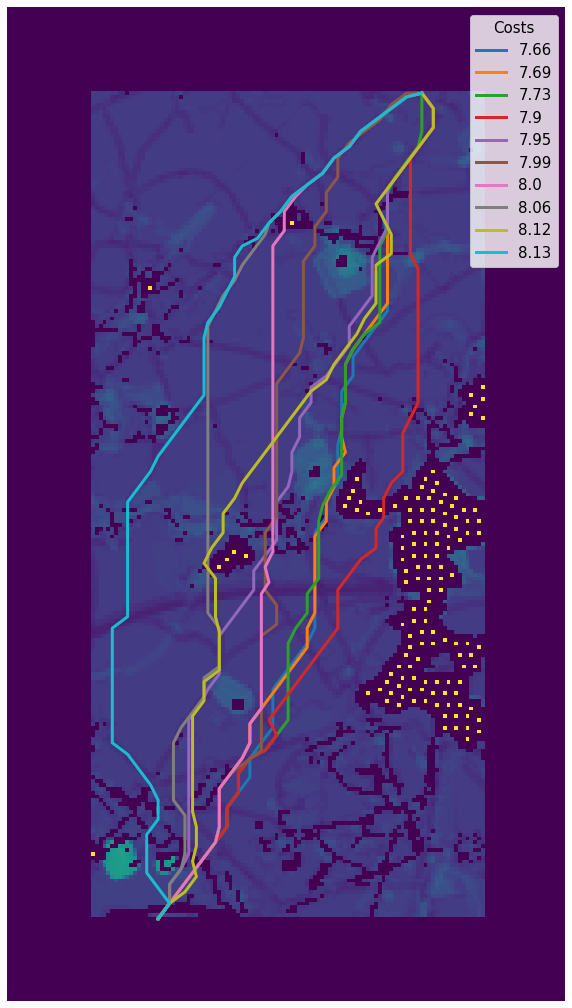

---------------   MODE:  max_norm_sim -------------------


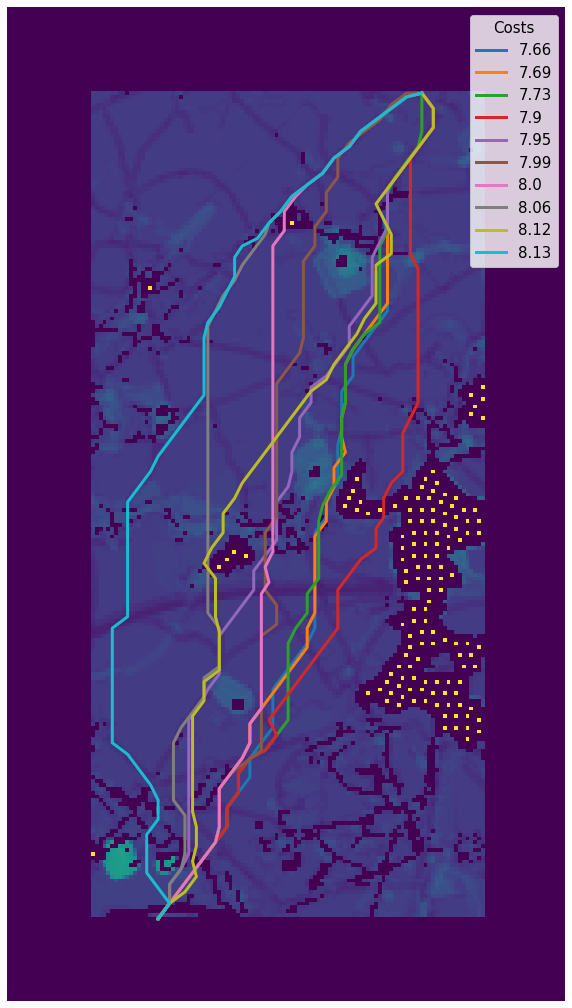

---------------   MODE:  min_norm_sim -------------------


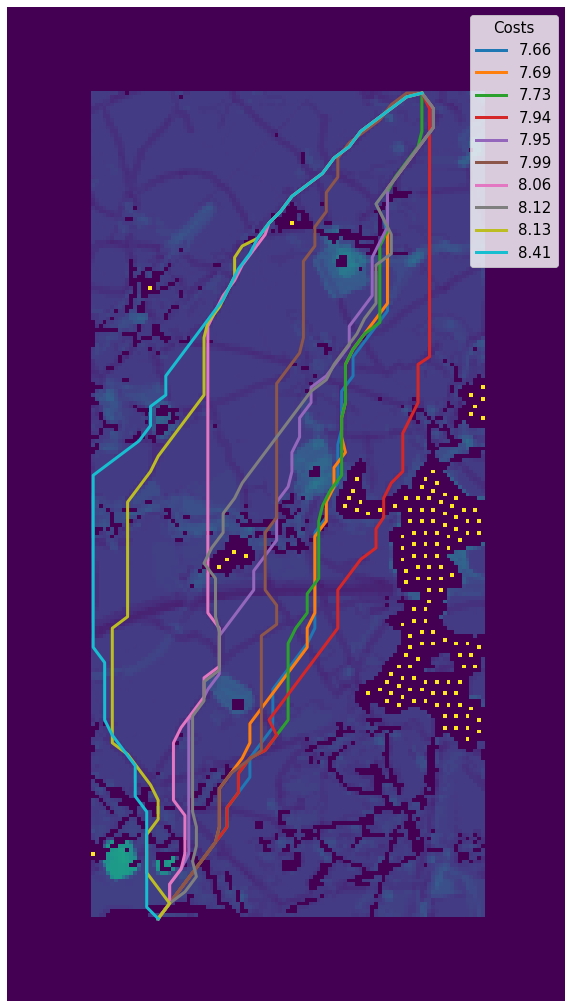

In [28]:
for mode in ["myset", "IoU","sim2paper", "sim3paper", "max_norm_sim", "min_norm_sim"]:
    ksp = k_shortest_paths(graph, source_v, target_v, 10, overlap=0.3, mode=mode)
    print("---------------   MODE: ", mode, "-------------------")
    plot_k_sp(ksp, graph.instance, out_path=None)

## Observations:

* very similar results in general
* IoU requires lower threshold than others (leading to less diverse paths)
* min and max norm do differ slightly in this example
* my set does only differ from others in this example by exchanging two paths (-->80% paths are same)